# Evaluation of the health of forests in Bhutan
#### Analysis with satellite images of Modis
#### Presentation of the NDVI Index for a quick assessment of the health of forests in Bhutan.

In [1]:
# Import necessary packages
import os
import json
import up42
import folium
import numpy as np
import rasterio as rio
from rasterio import plot
import matplotlib.cm as cm
from folium import plugins
from matplotlib import pyplot
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from rasterio.plot import reshape_as_raster, show

################################# Not use ######################################
#import geopandas as gpd                                                       #
#import pandas as pd                                                           #
#import pyproj                                                                 #
#from rasterio import features                                                 #
#from rasterio.warp import calculate_default_transform, reproject, Resampling  #
#from shapely.geometry import LineString, MultiPolygon, Point, Polygon, box    #
#from shapely.geometry import shape as shapely_shp                             #
#from shapely.ops import cascaded_union, transform                             #
################################################################################

In [2]:
# allows for ignoring errors + division by zero
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
# set directory to download the results
modis_dir = "./results/modis/"

In [4]:
# Authentification
# https://console.up42.com/ --> Developers
up42.authenticate(project_id="a7c22b41-77e4-4858-a90f-d22caa7788c2", 
                  project_api_key="XFhdgIzI.PqLIPJQXqucVbEf3wtNGlZ8lw2DiH7aBZWF")

2021-06-30 14:29:03,550 - Authentication with UP42 successful!


In [5]:
# Checking the blocks
#up42.get_blocks()
#up42.get_block_details()

In [6]:
# Get the current working directory
os.getcwd()

'/home/diego/GITHUP_REPO/Challenge_up42'

### Catalog Search
#### Search cloudfree Modis images for the AOI and visualise the quicklooks.

In [7]:
# Geojason of the Bhutan forest
# obtained from https://mapcruzin.com/bhutan-shapefiles/bhutan_natural.zip
# Read the area of interest with Up42 package

aoi = up42.read_vector_file('bhutan_forest_extent.geojson', as_dataframe=False)
#aoi

In [8]:
project = up42.initialize_project()
    
# init workflow
workflow = project.create_workflow(name="forests_bhutan_Modis", use_existing=True)
#print(up42.get_blocks(basic=True))

2021-06-30 14:29:04,758 - Initialized Project(name: Up42_challenge, project_id: a7c22b41-77e4-4858-a90f-d22caa7788c2, description: Evaluate the health of forests in Bhutan - Bruno Brazil Associates, createdAt: 2021-06-29T13:45:22.401521Z)
2021-06-30 14:29:04,760 - Getting existing workflows in project ...
2021-06-30 14:29:05,837 - Got 2 workflows for project a7c22b41-77e4-4858-a90f-d22caa7788c2.
100%|██████████| 2/2 [00:01<00:00,  1.58it/s]
2021-06-30 14:29:07,114 - Using existing workflow: forests_bhutan_Modis - 9a0db6b5-9854-4084-ac9d-5fef90f56c9f


In [9]:
input_tasks = ["nasa-modis"]

# Update workflow object with our desired data block as input_task(s)
workflow.add_workflow_tasks(input_tasks=input_tasks)
workflow

2021-06-30 14:29:11,134 - Added tasks to workflow: [{'name': 'nasa-modis:1', 'parentName': None, 'blockId': 'ef6faaf5-8182-4986-bce4-4f811d2745e5'}]


Workflow(name: forests_bhutan_Modis, workflow_id: 9a0db6b5-9854-4084-ac9d-5fef90f56c9f, description: , createdAt: 2021-06-30T12:25:51.213521Z, project_id: a7c22b41-77e4-4858-a90f-d22caa7788c2, workflow_tasks: {'nasa-modis:1': '2.2.4'}

In [10]:
# Construct input parameters
input_parameters = workflow.construct_parameters(geometry=aoi,
                                                 geometry_operation="intersects",
                                                 start_date="2020-01-01",
                                                 end_date="2021-06-25")

input_parameters['nasa-modis:1'].update({"max_cloud_cover":10})

input_parameters

2021-06-30 14:29:12,755 - The provided geometry contains multiple geometries, the union feature is taken instead.


{'nasa-modis:1': {'time': '2020-01-01T00:00:00Z/2021-06-25T23:59:59Z',
  'limit': 1,
  'zoom_level': 9,
  'imagery_layers': ['MODIS_Terra_CorrectedReflectance_TrueColor'],
  'intersects': {'type': 'Polygon',
   'coordinates': (((88.8358386, 26.6018439),
     (88.8358386, 28.39075),
     (92.2028439, 28.39075),
     (92.2028439, 26.6018439),
     (88.8358386, 26.6018439)),)},
  'max_cloud_cover': 10}}

In [11]:
# Price estimation
workflow.estimate_job(input_parameters)

2021-06-30 14:29:21,366 - Estimated: 1-1 Credits, Duration: 0-0 min.


{'nasa-modis:1': {'blockConsumption': {'resources': {'unit': 'SQUARE_KM',
    'min': 115290.052218,
    'max': 115290.052218},
   'credit': {'min': 0, 'max': 0}},
  'machineConsumption': {'duration': {'min': 0, 'max': 0},
   'credit': {'min': 1, 'max': 1}}}}

In [12]:
# Run a test job to query data availability and check the configuration.
test_job = workflow.test_job(input_parameters, track_status=True)

2021-06-30 14:29:21,385 - +++++++++++++++++++++++++++++++++
2021-06-30 14:29:21,392 - Running this job as Test Query...
2021-06-30 14:29:21,397 - +++++++++++++++++++++++++++++++++
2021-06-30 14:29:21,398 - Selected input_parameters: {'nasa-modis:1': {'time': '2020-01-01T00:00:00Z/2021-06-25T23:59:59Z', 'limit': 1, 'zoom_level': 9, 'imagery_layers': ['MODIS_Terra_CorrectedReflectance_TrueColor'], 'intersects': {'type': 'Polygon', 'coordinates': (((88.8358386, 26.6018439), (88.8358386, 28.39075), (92.2028439, 28.39075), (92.2028439, 26.6018439), (88.8358386, 26.6018439)),)}, 'max_cloud_cover': 10}, 'config': {'mode': 'DRY_RUN'}}
2021-06-30 14:29:23,010 - Created and running new job: 7dee1d1f-8d0b-4313-b000-b17988b095f7.
2021-06-30 14:29:23,499 - Tracking job status continuously, reporting every 30 seconds...
2021-06-30 14:29:40,639 - Job finished successfully! - 7dee1d1f-8d0b-4313-b000-b17988b095f7


In [13]:
# run the actual job
job = workflow.run_job(input_parameters=input_parameters, track_status=True)

2021-06-30 14:29:45,651 - Selected input_parameters: {'nasa-modis:1': {'time': '2020-01-01T00:00:00Z/2021-06-25T23:59:59Z', 'limit': 1, 'zoom_level': 9, 'imagery_layers': ['MODIS_Terra_CorrectedReflectance_TrueColor'], 'intersects': {'type': 'Polygon', 'coordinates': (((88.8358386, 26.6018439), (88.8358386, 28.39075), (92.2028439, 28.39075), (92.2028439, 26.6018439), (88.8358386, 26.6018439)),)}, 'max_cloud_cover': 10}}
2021-06-30 14:29:51,445 - Created and running new job: 4f35724d-d3cc-4d46-a1a7-b5af9d9a19db.
2021-06-30 14:29:51,892 - Tracking job status continuously, reporting every 30 seconds...
2021-06-30 14:30:25,685 - Job finished successfully! - 4f35724d-d3cc-4d46-a1a7-b5af9d9a19db


In [14]:
# Download results and quicklooks to results/sentinel/ folder in current directory
job.download_results(modis_dir)
job.download_quicklooks(modis_dir)

2021-06-30 14:30:30,705 - Downloading results of job 4f35724d-d3cc-4d46-a1a7-b5af9d9a19db
2021-06-30 14:30:30,708 - Download directory: results/modis
3995it [00:00, 167652.98it/s]
2021-06-30 14:30:32,567 - Download successful of 2 files to output_directory 'results/modis': ['data.json', '0c198a40-d363-499a-94d1-09bd4287bebc.tif']
2021-06-30 14:30:33,864 - Download directory: results/modis
100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


['results/modis/quicklook_0c198a40-d363-499a-94d1-09bd4287bebc.jpg']

In [15]:
# store results and quicklook paths to separate variables
raster_path = [i for i in job.results if i.endswith('.tif')][0]
metadata_path = [i for i in job.results if i.endswith('.json')][0]

In [16]:
# similarly store path for quicklook
ql_path = job.quicklooks[0]

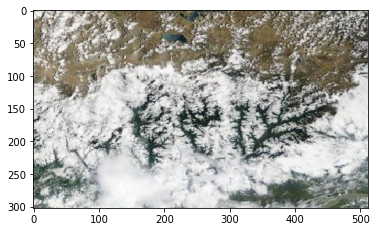

In [17]:
# We plot each quicklook until find the latest and cloudless image
img = mpimg.imread(ql_path)
imgplot = plt.imshow(img)
plt.show()